# Part 1: Validation of Series-Parallel (SP) Diploid Construction

## Objective
To demonstrate and validate the linear-time diploid expansion of Series-Parallel graphs (specifically "Bubble" motifs or P-nodes).

## Methodology
1.  **Visualization:** We first apply the algorithm to a single biological bubble to visualize the splitting of haplotypes.
2.  **Validation:** We generate a random "Chain of Bubbles" (pure SP graph) to verify the size formula:
    $$|V_{diploid}| = |V_{input}| + 2|P|$$

>>> PIPELINE STARTED

--- 1. Input Sequence Graph ---


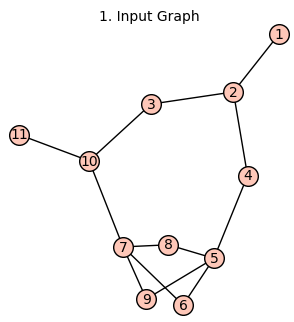


--- 2. SPQR Decomposition ---


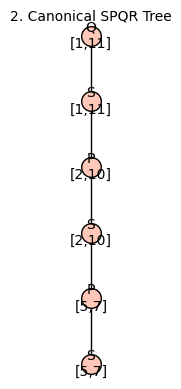


--- 3. Diploid Graph Construction ---


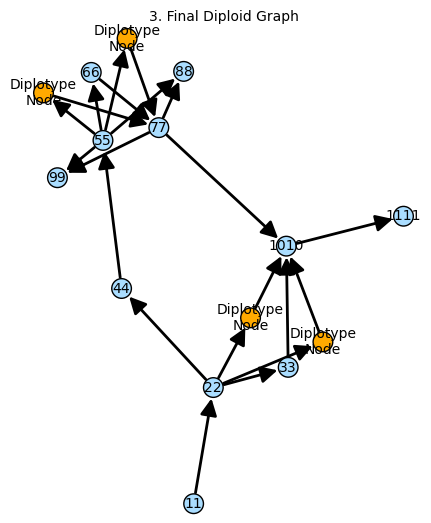


      GRAPH SIZE COMPARISON REPORT      
Input Haploid Graph (G):
  Nodes: 11
  Edges: 13
----------------------------------------
Output Diploid Graph (GD):
  Nodes: 15
  Edges: 21
----------------------------------------
Growth Factor (Nodes): 1.36x
Growth Factor (Edges): 1.62x


In [15]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import traceback

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_shared_vertices(g1, g2):
    """Returns vertices shared between two graph objects."""
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    return list(v1.intersection(v2))

# ==========================================
# 3. PART A: CANONICAL SPQR TREE
# ==========================================
def analyze_canonical_spqr(G, source_node, sink_node):
    """
    Decomposes graph G into an SPQR tree rooted at the Reference Edge (Q-node).
    """
    # Prepare Graph
    G_multi = Graph(G, multiedges=True)
    ref_edge_label = "REFERENCE_EDGE"
    
    # Ensure reference edge exists
    if source_node in G_multi and sink_node in G_multi:
        if not G_multi.has_edge(source_node, sink_node):
            G_multi.add_edge(source_node, sink_node, label=ref_edge_label)
    else:
        raise ValueError(f"Source {source_node} or Sink {sink_node} not in graph")

    # Compute SPQR
    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()
    
    # Find the Start Point (Child of Virtual Root)
    first_child_node = None
    
    # --- FIX APPLIED HERE ---
    # We must check if vertices exist in the subgraph BEFORE checking for the edge
    for node in T.vertices(sort=False):
        node_type, subgraph = node
        
        # Safety Check: Do these nodes even exist in this component?
        if source_node in subgraph and sink_node in subgraph:
            # Now it is safe to check for the edge
            if subgraph.has_edge(source_node, sink_node):
                first_child_node = node
                break
            
    if not first_child_node:
        # Fallback: If exact edge match fails, look for any component containing both nodes
        # (Sometimes Sage merges the Q-edge into a larger component)
        for node in T.vertices(sort=False):
            node_type, subgraph = node
            if source_node in subgraph and sink_node in subgraph:
                first_child_node = node
                break

    if not first_child_node:
        raise ValueError("Error: Reference edge lost in decomposition.")

    # Construct Display Tree (Rooted at Q)
    root_q = {
        'id': 'ROOT_Q',
        'type': 'Q',
        'terminals': [source_node, sink_node],
        'sage_obj': None, 
        'parent_id': None
    }
    
    queue = [(first_child_node, root_q)] 
    visited = {first_child_node}
    all_nodes = [root_q]
    node_counter = 0
    
    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        # Calculate Terminals
        if parent_display['id'] == 'ROOT_Q':
            terms = [source_node, sink_node]
        else:
            terms = get_shared_vertices(curr_subgraph, parent_display['sage_obj'])
            if not terms: 
                terms = [source_node, sink_node] 

        node_id = f"{curr_type}_{node_counter}"
        node_counter += 1
        
        display_node = {
            'id': node_id,
            'type': curr_type,
            'terminals': terms,
            'sage_obj': curr_subgraph,
            'parent_id': parent_display['id']
        }
        
        all_nodes.append(display_node)
        
        for neighbor in T.neighbor_iterator(curr_sage):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, display_node))

    # Visualize SPQR Tree
    VizTree = Graph()
    labels = {}
    for node in all_nodes:
        term_str = f"[{node['terminals'][0]},{node['terminals'][1]}]" if len(node['terminals'])==2 else str(node['terminals'])
        lbl = f"{node['type']}\n{term_str}"
        labels[node['id']] = lbl
        if node['parent_id']:
            VizTree.add_edge(labels[node['parent_id']], lbl)
            
    VizTree.show(layout='tree', tree_root=labels['ROOT_Q'], title="2. Canonical SPQR Tree", figsize=6)
    
    return all_nodes

# ==========================================
# 4. PART B: DIPLOID CONSTRUCTION
# ==========================================
def construct_diploid_graph(G, spqr_nodes):
    """
    Builds a Diploid Graph using P-nodes from SPQR as hetero-sites.
    """
    GD = DiGraph(multiedges=True)
    
    # --- Step A: Homozygous Backbone ---
    for v in G.vertices(sort=False):
        GD.add_vertex((v, v))
        
    for u, v, l in G.edges(sort=False):
        GD.add_edge((u, u), (v, v), label="backbone")

    # --- Step B: Insert Variants (P-nodes) ---
    p_nodes = [n for n in spqr_nodes if n['type'] == 'P']

    for p_node in p_nodes:
        terms = p_node['terminals']
        s, t = terms[0], terms[1]
        
        try:
            # Find paths strictly between s and t
            raw_paths = G.all_paths(s, t)
        except:
            continue
            
        # Filter paths > length 1 (to avoid reference edge or trivial edges)
        paths = [tuple(p) for p in raw_paths if len(p) > 1]
        
        if len(paths) < 2:
            continue
            
        path_p = paths[0]
        path_q = paths[1]
        
        node_pq = f"Het\n({path_p},\n{path_q})"
        node_qp = f"Het\n({path_q},\n{path_p})"
        
        GD.add_vertex(node_pq)
        GD.add_vertex(node_qp)
        
        start_hom = (s, s)
        end_hom = (t, t)
        
        GD.add_edge(start_hom, node_pq, label="diploid")
        GD.add_edge(node_pq, end_hom, label="diploid")
        GD.add_edge(start_hom, node_qp, label="diploid")
        GD.add_edge(node_qp, end_hom, label="diploid")
        
    return GD

def visualize_diploid(GD):
    color_map = {'#aaddff': [], '#ffaa00': []} 
    labels = {}
    
    for v in GD.vertices(sort=False):
        if isinstance(v, str) and "Het" in v:
            color_map['#ffaa00'].append(v)
            labels[v] = "Diplotype\nNode" 
        else:
            color_map['#aaddff'].append(v)
            labels[v] = str(v).replace("(", "").replace(")", "").replace(", ", "")
            
    GD.show(layout='spring', vertex_colors=color_map, vertex_labels=labels, title="3. Final Diploid Graph", figsize=8)

# ==========================================
# 5. EXECUTION
# ==========================================

# --- DEFINE HARDER NESTED GRAPH ---
# Structure: 1->2, Bubble(2->3->10, 2->4->5->(nested bubble 5->7)->7->10), 10->11
G = Graph()
# Backbone
G.add_edges([(1,2), (10,11)])
# Outer Bubble paths
G.add_edges([(2,3), (3,10)]) # Path A
G.add_edges([(2,4), (4,5), (7,10)]) # Path B (broken by inner bubble)
# Inner Bubble paths (between 5 and 7)
G.add_edges([(5,6), (6,7)]) 
G.add_edges([(5,8), (8,7)]) 
G.add_edges([(5,9), (9,7)]) 

print(">>> PIPELINE STARTED")

try:
    # 1. VISUALIZE INPUT
    print("\n--- 1. Input Sequence Graph ---")
    G.show(layout='spring', title="1. Input Graph", figsize=5)
    
    # 2. SPQR ANALYSIS
    print("\n--- 2. SPQR Decomposition ---")
    # Use Integer() just to be absolutely safe
    spqr_results = analyze_canonical_spqr(G, Integer(1), Integer(11))
    
    # 3. DIPLOID CONSTRUCTION
    print("\n--- 3. Diploid Graph Construction ---")
    GD = construct_diploid_graph(G, spqr_results)
    visualize_diploid(GD)
    
    # 4. REPORT
    input_nodes = G.order()
    input_edges = G.size()
    diploid_nodes = GD.order()
    diploid_edges = GD.size()
    
    print("\n" + "="*40)
    print("      GRAPH SIZE COMPARISON REPORT      ")
    print("="*40)
    print(f"Input Haploid Graph (G):")
    print(f"  Nodes: {input_nodes}")
    print(f"  Edges: {input_edges}")
    print("-" * 40)
    print(f"Output Diploid Graph (GD):")
    print(f"  Nodes: {diploid_nodes}")
    print(f"  Edges: {diploid_edges}")
    print("-" * 40)
    print(f"Growth Factor (Nodes): {diploid_nodes / input_nodes:.2f}x")
    print(f"Growth Factor (Edges): {diploid_edges / input_edges:.2f}x")
    print("="*40)
    
except Exception as e:
    traceback.print_exc()

>>> GENERATING COMPLEX GRAPH...
Graph Generated. Nodes: 20, Edges: 26

--- 1. Input Graph ---


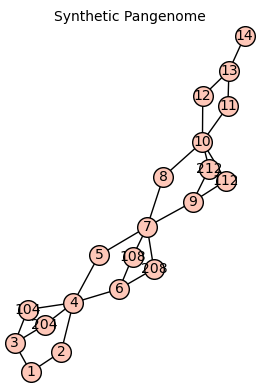


--- 2. SPQR Tree Generated ---


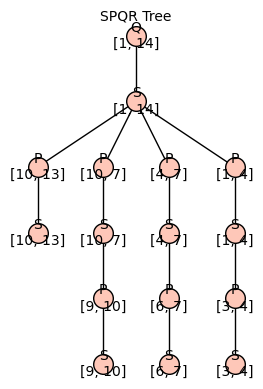


--- 3. Diploid Graph Visualization ---


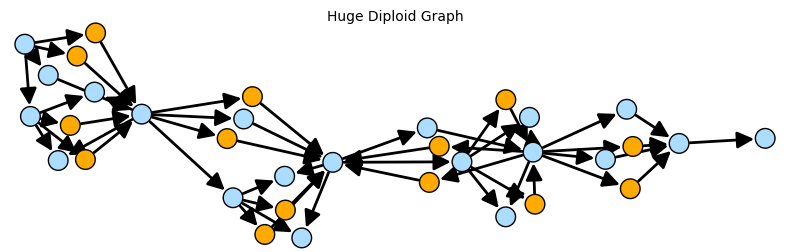


      EFFICIENCY & ACCURACY REPORT      
Bubbles (P-nodes) Processed: 7
--------------------------------------------------
METRIC     | PREDICTED  | ACTUAL     | STATUS
--------------------------------------------------
Nodes      | 34         | 34         | ✅ OK
Edges      | 54         | 54         | ✅ OK


In [16]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import random
import traceback

# ==========================================
# 2. CORE ALGORITHMS (SPQR + DIPLOID)
# ==========================================
def get_shared_vertices(g1, g2):
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    return list(v1.intersection(v2))

def analyze_canonical_spqr(G, source_node, sink_node):
    # --- Prepare ---
    G_multi = Graph(G, multiedges=True)
    ref_edge_label = "REFERENCE_EDGE"
    if source_node not in G_multi or sink_node not in G_multi:
        raise ValueError("Source/Sink not in graph")
    if not G_multi.has_edge(source_node, sink_node):
        G_multi.add_edge(source_node, sink_node, label=ref_edge_label)

    # --- Decompose ---
    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()
    
    # --- Find Root ---
    first_child_node = None
    for node in T.vertices(sort=False):
        node_type, subgraph = node
        if source_node in subgraph and sink_node in subgraph:
            if subgraph.has_edge(source_node, sink_node):
                first_child_node = node
                break
    
    if not first_child_node:
        # Fallback search
        for node in T.vertices(sort=False):
            node_type, subgraph = node
            if source_node in subgraph and sink_node in subgraph:
                first_child_node = node
                break

    if not first_child_node:
        raise ValueError("Reference edge lost.")

    # --- Build Tree ---
    root_q = {'id': 'ROOT_Q', 'type': 'Q', 'terminals': [source_node, sink_node], 'sage_obj': None, 'parent_id': None}
    queue = [(first_child_node, root_q)] 
    visited = {first_child_node}
    all_nodes = [root_q]
    node_counter = 0
    
    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        if parent_display['id'] == 'ROOT_Q':
            terms = [source_node, sink_node]
        else:
            terms = get_shared_vertices(curr_subgraph, parent_display['sage_obj'])
            if not terms: terms = [source_node, sink_node] 

        node_id = f"{curr_type}_{node_counter}"
        node_counter += 1
        
        display_node = {
            'id': node_id, 'type': curr_type, 'terminals': terms,
            'sage_obj': curr_subgraph, 'parent_id': parent_display['id']
        }
        all_nodes.append(display_node)
        
        for neighbor in T.neighbor_iterator(curr_sage):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, display_node))

    # --- Visualize SPQR ---
    VizTree = Graph()
    labels = {}
    for n in all_nodes:
        t_str = str(n['terminals'])
        lbl = f"{n['type']}\n{t_str}"
        labels[n['id']] = lbl
        if n['parent_id']: VizTree.add_edge(labels[n['parent_id']], lbl)
    print("\n--- 2. SPQR Tree Generated ---")
    VizTree.show(layout='tree', tree_root=labels['ROOT_Q'], title="SPQR Tree", figsize=6)
    
    return all_nodes

def construct_diploid_graph(G, spqr_nodes):
    GD = DiGraph(multiedges=True)
    
    # Backbone
    for v in G.vertices(sort=False): GD.add_vertex((v, v))
    for u, v, l in G.edges(sort=False): GD.add_edge((u, u), (v, v), label="backbone")

    # P-nodes
    p_nodes = [n for n in spqr_nodes if n['type'] == 'P']
    
    count_valid_p = 0
    
    for p_node in p_nodes:
        terms = p_node['terminals']
        s, t = terms[0], terms[1]
        try:
            raw_paths = G.all_paths(s, t)
        except: continue
        paths = [tuple(p) for p in raw_paths if len(p) > 1] # Filter ref edge
        
        if len(paths) < 2: continue
        
        count_valid_p += 1
        path_p, path_q = paths[0], paths[1]
        
        node_pq = f"Het{count_valid_p}_A"
        node_qp = f"Het{count_valid_p}_B"
        GD.add_vertex(node_pq)
        GD.add_vertex(node_qp)
        
        s_hom, t_hom = (s, s), (t, t)
        GD.add_edge(s_hom, node_pq, label="diploid")
        GD.add_edge(node_pq, t_hom, label="diploid")
        GD.add_edge(s_hom, node_qp, label="diploid")
        GD.add_edge(node_qp, t_hom, label="diploid")
        
    return GD, count_valid_p

# ==========================================
# 3. RANDOM GRAPH GENERATOR
# ==========================================
def generate_random_pangenome(num_bubbles=3, nested_prob=0.5):
    """Generates a linear graph with random bubbles and nested bubbles."""
    G = Graph()
    current_node = 1
    
    # Start backbone
    G.add_vertex(current_node)
    
    for i in range(num_bubbles):
        start = current_node
        end = current_node + 3 # Jump ahead
        
        # 1. Create Main Backbone Path
        # start -> mid1 -> end
        mid1 = current_node + 1
        mid2 = current_node + 2 # Not used in backbone, reserved for bubble
        
        G.add_edge(start, mid1)
        G.add_edge(mid1, end)
        
        # 2. Create Bubble Path
        # start -> mid2 -> end
        G.add_edge(start, mid2)
        G.add_edge(mid2, end)
        
        # 3. Optional: Nesting (Add a bubble inside the 'mid2' path)
        if random.random() < nested_prob:
            # Break mid2->end and insert a new node 'nested'
            G.delete_edge(mid2, end)
            nested_node = end + 100 + i # High ID to avoid clash
            G.add_edge(mid2, nested_node)
            G.add_edge(nested_node, end)
            
            # Add alternative path for nesting: mid2 -> alt -> end
            alt_nested = end + 200 + i
            G.add_edge(mid2, alt_nested)
            G.add_edge(alt_nested, end)
            
        current_node = end
        
    # Add final tail
    G.add_edge(current_node, current_node + 1)
    
    return G, 1, current_node + 1

# ==========================================
# 4. EXECUTION & VERIFICATION
# ==========================================
print(">>> GENERATING COMPLEX GRAPH...")
# Create a graph with 4 bubbles, 50% chance of them being nested
G, src, snk = generate_random_pangenome(num_bubbles=4, nested_prob=0.5)

print(f"Graph Generated. Nodes: {G.order()}, Edges: {G.size()}")
print("\n--- 1. Input Graph ---")
G.show(layout='spring', figsize=6, title="Synthetic Pangenome")

try:
    # 1. Analyze
    spqr_nodes = analyze_canonical_spqr(G, src, snk)
    
    # 2. Construct
    GD, num_p_used = construct_diploid_graph(G, spqr_nodes)
    
    # 3. Visualize Result
    print("\n--- 3. Diploid Graph Visualization ---")
    color_map = {'#aaddff': [], '#ffaa00': []} 
    for v in GD.vertices(sort=False):
        if isinstance(v, str) and "Het" in v: color_map['#ffaa00'].append(v)
        else: color_map['#aaddff'].append(v)
    GD.show(layout='spring', vertex_colors=color_map, vertex_labels=False, title="Huge Diploid Graph", figsize=8)
    
    # 4. FORMULA VERIFICATION
    V_in = G.order()
    E_in = G.size()
    P_count = num_p_used
    
    # Theoretical Formula
    V_pred = V_in + (2 * P_count)
    E_pred = E_in + (4 * P_count)
    
    # Actual Size
    V_act = GD.order()
    E_act = GD.size()
    
    print("\n" + "="*50)
    print("      EFFICIENCY & ACCURACY REPORT      ")
    print("="*50)
    print(f"Bubbles (P-nodes) Processed: {P_count}")
    print("-" * 50)
    print(f"{'METRIC':<10} | {'PREDICTED':<10} | {'ACTUAL':<10} | {'STATUS'}")
    print("-" * 50)
    
    v_status = "✅ OK" if V_pred == V_act else "❌ FAIL"
    e_status = "✅ OK" if E_pred == E_act else "❌ FAIL"
    
    print(f"{'Nodes':<10} | {V_pred:<10} | {V_act:<10} | {v_status}")
    print(f"{'Edges':<10} | {E_pred:<10} | {E_act:<10} | {e_status}")
    print("="*50)

except Exception as e:
    traceback.print_exc()

>>> GENERATING GRAPH & RUNNING ANALYSIS...

          MATHEMATICAL RELATIONSHIP REPORT
1. INPUT DATA
   Input Nodes (V_in) : 20
   Input Edges (E_in) : 25
   Bubbles Found (|P|): 6
------------------------------------------------------------
2. THEORETICAL FORMULA
   V_diploid = V_in + 2 * |P|
   E_diploid = E_in + 4 * |P|
------------------------------------------------------------
3. CALCULATION STEP
   Nodes Calculation : 20 + (2 * 6) = 32
   Edges Calculation : 25 + (4 * 6) = 49
------------------------------------------------------------
4. VERIFICATION
   Actual Diploid Nodes: 32  ---> MATCH
   Actual Diploid Edges: 49  ---> MATCH
------------------------------------------------------------
5. RELATION (Expansion Factor)
   Ratio (V_out / V_in): 1.60x
   (The graph grew by 1.60 times its original size)

Displaying Diploid Graph...


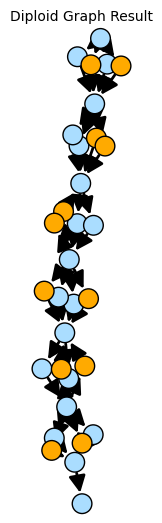

In [18]:
# ==========================================
# 1. IMPORTS
# ==========================================
from sage.all import *
from sage.graphs.connectivity import TriconnectivitySPQR
import random
import traceback

# ==========================================
# 2. ROBUST FUNCTIONS
# ==========================================
def get_shared_vertices(g1, g2):
    v1 = set(g1.vertices(sort=False))
    v2 = set(g2.vertices(sort=False))
    return list(v1.intersection(v2))

def analyze_canonical_spqr(G, source_node, sink_node):
    # 1. Prepare Multigraph with Reference Edge
    G_multi = Graph(G, multiedges=True)
    if source_node not in G_multi or sink_node not in G_multi:
        raise ValueError(f"Terminals {source_node}-{sink_node} not found.")
    
    if not G_multi.has_edge(source_node, sink_node):
        G_multi.add_edge(source_node, sink_node, label="REFERENCE_EDGE")

    # 2. SPQR Decomposition
    tric = TriconnectivitySPQR(G_multi)
    T = tric.get_spqr_tree()
    
    # 3. Find Root (Robust Search)
    root_node = None
    # First pass: Look for Q-node specifically
    for node in T.vertices(sort=False):
        node_type, subgraph = node
        if node_type == 'Q' and source_node in subgraph and sink_node in subgraph:
            if subgraph.has_edge(source_node, sink_node):
                root_node = node
                break
    
    # Second pass: Any node containing the edge
    if not root_node:
        for node in T.vertices(sort=False):
            node_type, subgraph = node
            if source_node in subgraph and sink_node in subgraph:
                if subgraph.has_edge(source_node, sink_node):
                    root_node = node
                    break
                    
    if not root_node: raise ValueError("Reference edge lost in SPQR tree.")

    # 4. Build Display List
    # Virtual Root Q
    root_q = {'id': 'ROOT_Q', 'type': 'Q', 'terminals': [source_node, sink_node], 'sage_obj': None, 'parent_id': None}
    
    # Start traversal from the actual Sage node found
    queue = [(root_node, root_q)] 
    visited = {root_node}
    all_nodes = [root_q]
    node_counter = 0
    
    while queue:
        curr_sage, parent_display = queue.pop(0)
        curr_type, curr_subgraph = curr_sage
        
        # Calc Terminals
        if parent_display['id'] == 'ROOT_Q':
            terms = [source_node, sink_node]
        else:
            terms = get_shared_vertices(curr_subgraph, parent_display['sage_obj'])
            if not terms: terms = [source_node, sink_node] 

        node_id = f"{curr_type}_{node_counter}"
        node_counter += 1
        
        display_node = {
            'id': node_id, 'type': curr_type, 'terminals': terms,
            'sage_obj': curr_subgraph, 'parent_id': parent_display['id']
        }
        all_nodes.append(display_node)
        
        for neighbor in T.neighbor_iterator(curr_sage):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, display_node))
                
    return all_nodes

def construct_diploid_graph(G, spqr_nodes):
    GD = DiGraph(multiedges=True)
    
    # Backbone
    for v in G.vertices(sort=False): GD.add_vertex((v, v))
    for u, v, l in G.edges(sort=False): GD.add_edge((u, u), (v, v), label="backbone")

    # Variants
    p_nodes = [n for n in spqr_nodes if n['type'] == 'P']
    count_valid_p = 0
    
    for p_node in p_nodes:
        terms = p_node['terminals']
        s, t = terms[0], terms[1]
        try:
            raw_paths = G.all_paths(s, t)
        except: continue
        
        paths = [tuple(p) for p in raw_paths if len(p) > 1]
        if len(paths) < 2: continue
        
        count_valid_p += 1
        p_path, q_path = paths[0], paths[1]
        
        # Add 2 Hetero Nodes
        pq_node = f"Het{count_valid_p}_A"
        qp_node = f"Het{count_valid_p}_B"
        GD.add_vertex(pq_node)
        GD.add_vertex(qp_node)
        
        # Add 4 Wiring Edges
        s_h, t_h = (s, s), (t, t)
        GD.add_edge(s_h, pq_node); GD.add_edge(pq_node, t_h)
        GD.add_edge(s_h, qp_node); GD.add_edge(qp_node, t_h)
        
    return GD, count_valid_p

def generate_random_pangenome(num_bubbles=5):
    G = Graph()
    curr = 1
    G.add_vertex(curr)
    for i in range(num_bubbles):
        # Create a bubble: Start -> Mid1/Mid2 -> End
        start, end = curr, curr + 3
        G.add_edge(start, curr+1); G.add_edge(curr+1, end) # Path 1
        G.add_edge(start, curr+2); G.add_edge(curr+2, end) # Path 2
        curr = end
    G.add_edge(curr, curr+1) # Tail
    return G, 1, curr+1

# ==========================================
# 3. EXECUTION & DETAILED MATH REPORT
# ==========================================
print(">>> GENERATING GRAPH & RUNNING ANALYSIS...")

# 1. Generate
G, src, snk = generate_random_pangenome(num_bubbles=6)

try:
    # 2. Analyze
    spqr_results = analyze_canonical_spqr(G, src, snk)
    
    # 3. Construct
    GD, bubbles_used = construct_diploid_graph(G, spqr_results)
    
    # 4. DETAILED FORMULA REPORT
    V_in = G.order()
    E_in = G.size()
    P = bubbles_used
    
    V_out_actual = GD.order()
    E_out_actual = GD.size()
    
    print("\n" + "="*60)
    print("          MATHEMATICAL RELATIONSHIP REPORT")
    print("="*60)
    
    print(f"1. INPUT DATA")
    print(f"   Input Nodes (V_in) : {V_in}")
    print(f"   Input Edges (E_in) : {E_in}")
    print(f"   Bubbles Found (|P|): {P}")
    print("-" * 60)
    
    print(f"2. THEORETICAL FORMULA")
    print(f"   V_diploid = V_in + 2 * |P|")
    print(f"   E_diploid = E_in + 4 * |P|")
    print("-" * 60)
    
    print(f"3. CALCULATION STEP")
    print(f"   Nodes Calculation : {V_in} + (2 * {P}) = {V_in + 2*P}")
    print(f"   Edges Calculation : {E_in} + (4 * {P}) = {E_in + 4*P}")
    print("-" * 60)
    
    print(f"4. VERIFICATION")
    print(f"   Actual Diploid Nodes: {V_out_actual}  ---> {'MATCH' if V_out_actual == V_in + 2*P else 'MISMATCH'}")
    print(f"   Actual Diploid Edges: {E_out_actual}  ---> {'MATCH' if E_out_actual == E_in + 4*P else 'MISMATCH'}")
    print("-" * 60)
    
    # The Relation (Expansion Factor)
    growth = V_out_actual / V_in
    print(f"5. RELATION (Expansion Factor)")
    print(f"   Ratio (V_out / V_in): {growth:.2f}x")
    print(f"   (The graph grew by {growth:.2f} times its original size)")
    print("="*60)
    
    # Optional: Visualize the result
    print("\nDisplaying Diploid Graph...")
    color_map = {'#aaddff': [], '#ffaa00': []} 
    for v in GD.vertices(sort=False):
        if isinstance(v, str) and "Het" in v: color_map['#ffaa00'].append(v)
        else: color_map['#aaddff'].append(v)
    GD.show(layout='spring', vertex_colors=color_map, vertex_labels=False, title="Diploid Graph Result", figsize=8)

except Exception as e:
    traceback.print_exc()